In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd "/content/gdrive/My Drive/sumie"

/content/gdrive/My Drive/sumie


In [3]:
!pip install -r requirements.txt
import montage
import cppn

In [0]:
import torch
import torchvision
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline
%load_ext autoreload

%autoreload 2

In [5]:
!pip show pillow

Name: Pillow
Version: 5.4.0
Summary: Python Imaging Library (Fork)
Home-page: http://python-pillow.org
Author: Alex Clark (Fork Author)
Author-email: aclark@aclark.net
License: Standard PIL License
Location: /usr/local/lib/python3.6/dist-packages
Requires: 
Required-by: tflearn, magenta


Target shape = torch.Size([1, 3, 224, 224])


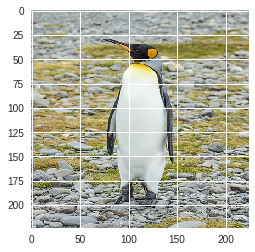

tensor([[[[0.6275, 0.6431, 0.7098,  ..., 0.4667, 0.4078, 0.4078],
          [0.5882, 0.6078, 0.6745,  ..., 0.3020, 0.5451, 0.5608],
          [0.5608, 0.6157, 0.6549,  ..., 0.4471, 0.8118, 0.4706],
          ...,
          [0.6275, 0.6706, 0.6588,  ..., 0.2196, 0.7490, 0.5725],
          [0.5529, 0.6549, 0.6275,  ..., 0.3098, 0.7137, 0.4980],
          [0.5451, 0.6275, 0.5686,  ..., 0.0000, 0.7020, 0.5725]],

         [[0.6745, 0.6745, 0.7255,  ..., 0.4824, 0.4353, 0.4471],
          [0.6353, 0.6431, 0.6902,  ..., 0.3176, 0.5725, 0.6000],
          [0.6000, 0.6510, 0.6784,  ..., 0.4667, 0.8510, 0.5137],
          ...,
          [0.6706, 0.7098, 0.7020,  ..., 0.2627, 0.7647, 0.5765],
          [0.5882, 0.6941, 0.6706,  ..., 0.3608, 0.7333, 0.5059],
          [0.5804, 0.6667, 0.6118,  ..., 0.0157, 0.7373, 0.5843]],

         [[0.6745, 0.6824, 0.7294,  ..., 0.4941, 0.4588, 0.4863],
          [0.6353, 0.6392, 0.6941,  ..., 0.3294, 0.5961, 0.6353],
          [0.5961, 0.6471, 0.6784,  ..., 0

In [22]:
filename = 'penguin.jpg'
im_width = 224
im_size = (im_width, im_width)
target = montage.load_image(filename, im_size) # (w,h)
target = target/255
print(f"Target shape = {target.size()}")
montage.show(255*target)
target.to(device)

In [7]:
from torchvision import models
model = models.vgg16(pretrained=True).features
model.eval()
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:07<00:00, 73622693.88it/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [0]:
class LearnableImage(torch.nn.Module):
    def __init__(self, size):
        super(LearnableImage, self).__init__()
        self.pixels = torch.nn.Parameter(0.1*torch.randn(1,3,size,size))
        
    def forward(self):
        #return self.pixels
        return torch.sigmoid(self.pixels)


In [0]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [0]:
class GramRecord():
    def __init__(self):
        self.value = None
        
    def hook(self, mod, hook_in, hook_out):
        conv_features = hook_out.clone()
        G = gram_matrix(conv_features)
        self.value = G
    
gram = GramRecord()
hook_ref = model[17].register_forward_hook(gram.hook)

In [0]:
def denormalise(in_tensor):
    mean = torch.as_tensor([0.485, 0.456, 0.406])
    std = torch.as_tensor([0.229, 0.224, 0.225])
    return in_tensor * std[None,:,None,None] + mean[None,:,None,None]
 
def normalise(in_tensor):
    mean = torch.as_tensor([0.485, 0.456, 0.406]).to(device)
    std = torch.as_tensor([0.229, 0.224, 0.225]).to(device)
    return (in_tensor - mean[None,:,None,None]) / std[None,:,None,None]
 

In [0]:
model.to(device)
out = model(normalise(target.to(device)))

TypeError: ignored

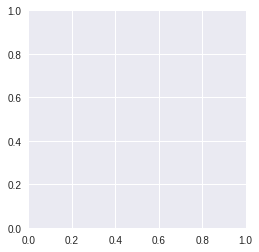

In [27]:
plt.imshow(gram.value.detach())
target_value = gram.value.detach()

tensor(0.0808, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward>)


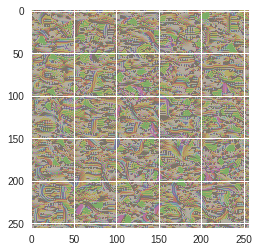

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
target_value.to(device)

image = LearnableImage(256).to(device)
model.to(device)
optimiser = torch.optim.Adam(image.parameters(), lr=1)
steps = 500
jitter = 8
criterion = torch.nn.MSELoss()
for i in range(steps):
    optimiser.zero_grad()
    input_image = image()
    input_image = torch.roll(input_image, 
                             np.random.randint(-jitter, jitter), 
                             dims=2)
    input_image = torch.roll(input_image, 
                             np.random.randint(-jitter, jitter), 
                             dims=3)
    
    model(normalise(input_image))
    
    loss = criterion(gram.value, target_value.to(device))
    if i % (steps/10) == 0:
        print(loss)
    loss.backward()
    optimiser.step()


montage.show(255*denormalise(image().cpu()))

In [0]:
plt.imshow(gram.value.detach())
plt.show()
plt.imshow(target_value)
plt.show()
#plt.plot(1*denormalise(image()).detach().numpy().ravel()[:100])
#print(image.pixels.grad)

In [0]:
for i in range(steps):
    optimiser.zero_grad()
    input_image = image()
    out = model(normalise(input_image))
    
    loss = criterion(gram.value, target_value)
    if i % (steps/10) == 0:
        print(loss)
    loss.backward()
    optimiser.step()

montage.show(255*image())

In [34]:
for idx, child in enumerate(model.children()):
    if isinstance(child, torch.nn.ReLU):
        model[idx] = torch.nn.ReLU(inplace=False)
    elif isinstance(child, torch.nn.MaxPool2d):
        model[idx] = torch.nn.AvgPool2d(kernel_size=child.kernel_size, stride=child.stride, padding=child.padding)
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU()
  (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (20): ReLU()
  (21): Conv2d(512, 512

In [0]:
image = LearnableImage(224)
optimiser = torch.optim.Adam(image.parameters(), lr=0.1)
steps = 100
criterion = torch.nn.MSELoss()
for i in range(steps):
    optimiser.zero_grad()
    input_image = image()
    out = model(normalise(input_image))
    
    loss = criterion(gram.value, target_value)
    if i % (steps/10) == 0:
        print(loss)
    loss.backward()
    optimiser.step()


montage.show(255*image())